Import Statements

In [2]:
import os, git, sys # install gitpython
git_root= git.Repo(os.path.abspath(''),search_parent_directories=True).git.rev_parse('--show-toplevel')
sys.path.append(git_root)
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import data.constants as const


In [3]:
const.SAVE_DIR

'C:/Users/kellychris/Personal Software/LifeFinances\\diagnostics/saved'

In [4]:
FILE_PATH = f'{const.SAVE_DIR}/worst_failure.csv'
#FILE_PATH = f'{const.SAVE_DIR}/saveData1.csv'

df = pd.read_csv(FILE_PATH)

with open(const.PARAMS_LOC) as json_file:
            params = json.load(json_file)
param_vals = {key:obj["val"] for (key,obj) in params.items()}

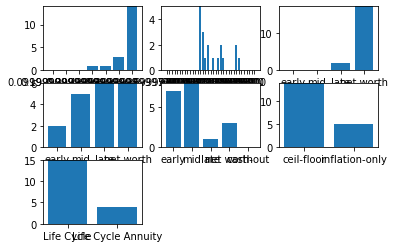

In [11]:
# Parameter Success Rates
with open(const.PARAMS_SUCCESS_LOC) as json_file:
            param_cnt = json.load(json_file)

fig = plt.figure()
plt_rects = {}
subplots = {}
size = math.ceil(math.sqrt(len(param_cnt.items())))
for i,param in enumerate(param_cnt.keys()):
    ax = fig.add_subplot(size,size,i+1)
    subplots[param] = ax
    options = list(param_cnt[param].keys())
    counts = list(param_cnt[param].values())
    rects = ax.bar(options,counts)
    plt_rects[param] = rects
    for idx, option in enumerate(param_cnt[param].keys()):
        plt_rects[param][idx].set_height(param_cnt[param][option])    
        subplots[param].set_ylim(0,max(param_cnt[param].values()))


Text(0, 0.5, 'Returns')

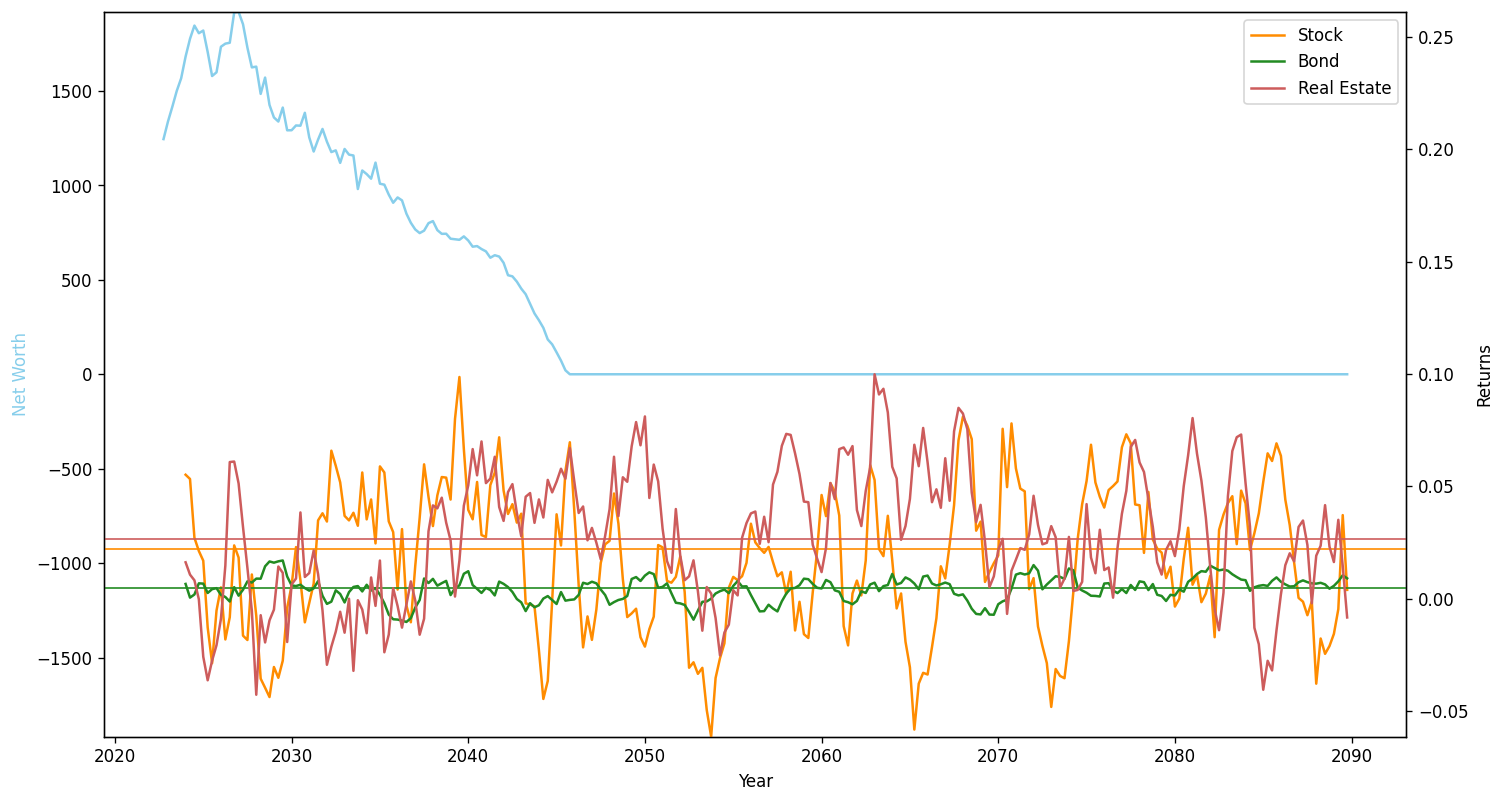

In [8]:
# Net Worth & returns
plt.figure(figsize=(14,8), dpi=120) 

roll_df = df[['Stock Returns', 'Bond Returns','RE Returns']].rolling(window=6).mean()

ax1 = plt.gca() # get the axis
ax2 = ax1.twinx() # create another axis that shares the same x-axis

ax1.set_ylim(bottom=-df['Net Worth'].max(), top=df['Net Worth'].max())
min_return, max_return = min(roll_df['Stock Returns'].min(),roll_df['RE Returns'].min()), max(roll_df['Stock Returns'].max(),roll_df['RE Returns'].max())
ax2.set_ylim(bottom=min_return, top=max_return+(max_return-min_return))

ax1.plot(df['Time'],df["Net Worth"], color='skyblue')
ax2.plot(df['Time'],roll_df["Stock Returns"], color='darkorange',label='Stock')
ax2.axhline(const.EQUITY_MEAN ** (1/4)-1, color='darkorange', lw=1)
ax2.plot(df['Time'],roll_df["Bond Returns"], color='forestgreen',label='Bond')
ax2.axhline(const.BOND_MEAN ** (1/4)-1, color='forestgreen', lw=1)
ax2.plot(df['Time'],roll_df["RE Returns"], color='indianred',label='Real Estate')
ax2.axhline(const.RE_MEAN ** (1/4)-1, color='indianred', lw=1)
plt.legend() 

ax1.set_xlabel('Year')
ax1.set_ylabel('Net Worth', color='skyblue')
ax2.set_ylabel('Returns')

Check rates

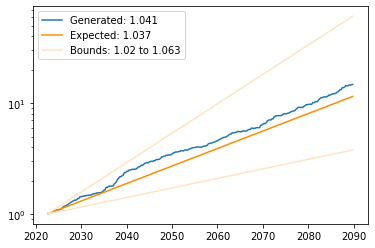

In [9]:
# Inflation
years = math.trunc(df['Time'].max()-df['Time'].min())
product = list(df['Inflation'])[-1]
annualized = pow(product, 1 / years)

plt.plot(df['Time'],df["Inflation"],label=f'Generated: {annualized:.3f}')

def expected_ls(val):
    qt_val = val ** (1/4)
    ls = [qt_val]
    for _ in df["Inflation"]:
        ls.append(ls[-1] * qt_val)
    ls.pop()
    return ls

expected_inflation_ls = expected_ls(const.INFLATION_MEAN)
low_ls = expected_ls(const.INFLATION_ANNUAL_LOW)
high_ls = expected_ls(const.INFLATION_ANNUAL_HIGH)

plt.plot(df['Time'],expected_inflation_ls,label=f'Expected: {const.INFLATION_MEAN}',color='darkorange')
plt.plot(df['Time'],low_ls,color='bisque',label=f'Bounds: {const.INFLATION_ANNUAL_LOW} to {const.INFLATION_ANNUAL_HIGH}')
plt.plot(df['Time'],high_ls,color='bisque')
plt.yscale('log')
plt.legend() 


1.070177318086639


,Generated,Expected
avg,1.070177,1.092


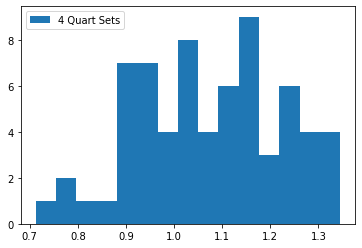

In [10]:
years = math.trunc(df['Time'].max()-df['Time'].min())
yr_sets_of_qt_returns=np.array_split((df['Stock Returns']+1),years)
yr_returns = []
for set in yr_sets_of_qt_returns:
        yr_returns.append(np.product(set))
plt.hist(yr_returns,15,label='4 Quart Sets')
print(np.mean(yr_returns))
plt.legend()

data = {'Generated':[np.mean(yr_returns)],
        'Expected':[const.EQUITY_MEAN]}

pd.DataFrame(data, index=['avg'
                               ])

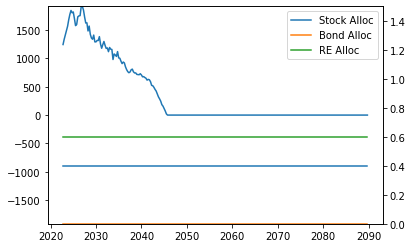

In [11]:
# Allocations over time

ax1 = plt.gca() # get the axis
ax2 = ax1.twinx() # create another axis that shares the same x-axis

ax1.set_ylim(bottom=-df['Net Worth'].max(), top=df['Net Worth'].max())
ax2.set_ylim(bottom=0, top=1.5)

ax1.plot(df['Time'],df["Net Worth"])
#ax1.axhline(y=param_vals['Equity Target'], color='r', linestyle='-') keeps drawing a line at 0, not sure why
ax2.plot(df['Time'],df["Stock Alloc"],label='Stock Alloc')
ax2.plot(df['Time'],df["Bond Alloc"],label='Bond Alloc')
ax2.plot(df['Time'],df["RE Alloc"],label='RE Alloc')
plt.legend()
